In [48]:
import re
import cv2
import time
import i2v
import json
import hashlib
import requests
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from absl import logging
from notifier import Notifier, notify
from alive_progress import alive_bar
from keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import (
  ReduceLROnPlateau,
  EarlyStopping,
  ModelCheckpoint,
  TensorBoard
)
from tensorflow.keras import mixed_precision

import os
import pandas as pd
import random as rd
import pickle as pkl
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

SEED=42
SIZE_IMG = 224 #224#224#416
UNITS = 1024 #128 #256 #512-seq
MAX_CLASS = 32 #32 32 8

DATASET_PATH='./data/animes'
DATASET_FACES_PATH='./data/faces'

DATASET_JSON_PATH='./data/anime_data.json'

AMOUNT_TABLE_PATH='./data/anime_amount.pkl'
AMOUNT_FACES_TABLE_PATH='./data/faces_amount.pkl'

DATASET_JSON_RANK='./data/anime_rank.json'

TFRECORD_PATH=F'./data/anime_data_{MAX_CLASS}.tfrecord'
TFRECORD_FACES_PATH='./data/anime_faces_data_{MAX_CLASS}.tfrecord'

TG_ID="293701727"
TG_TOKEN="1878628343:AAEFVRsqDz63ycmaLOFS7gvsG969wdAsJ0w"
WEBHOOK_URL="https://discord.com/api/webhooks/796406472459288616/PAkiGGwqe0_PwtBxXYQvOzbk78B4RQP6VWRkvpBtw6Av0sc_mDa3saaIlwVPFjOIeIbt"

if False:
  DATASET_PATH = DATASET_FACES_PATH
  TFRECORD_PATH = TFRECORD_FACES_PATH
  AMOUNT_TABLE_PATH = AMOUNT_FACES_TABLE_PATH

#seed random seed to 42 for reproducibility
rd.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

mixed_precision.set_global_policy('mixed_float16')

### Dataset anime

In [2]:
def dowload_image(url, anime_name, idx):
  #download image from url
  file_path = f'./data/animes/{anime_name}____{idx}.jpg' 
  if os.path.exists(file_path):
    return

  img_data = requests.get(url).content
  with open(file_path, 'wb') as handler:
    handler.write(img_data)

@notify(
  chat_id=TG_ID,
  api_token=TG_TOKEN,
  title='Anime images',
  msg='Finished downloading anime images'
)
def get_images(data):
  #with alive_bar(len(data)) as bar:
  for idx_a, anime_name in enumerate(data):
    urls = data[anime_name]
    for idx, url in enumerate(urls):
      if idx >= 400:
        break
      name_clean = re.sub(r'_+', r'_', re.sub(r'[\W\s]', r'_', anime_name))
      try:
        dowload_image(url['image'], name_clean, idx)
      except Exception as e:
        print(f'Error on download image {idx + 1} of {anime_name}')
        pass
    #bar()
    print(f'Progress: {idx_a + 1}/{len(data)} - {round((idx_a + 1)/len(data)*100, 2)}%')

def get_classes_anime(path):
  classes = set()
  for filename in os.listdir(path):
    class_name, _ = filename.split('____')
    classes.add(class_name)
  return list(classes)

def wait_for_it(driver, xpath, timeout=3):
  try:
    return WebDriverWait(driver, timeout).until(
        EC.presence_of_element_located((By.XPATH, xpath))
    )
  except Exception as e:
    return None

def iter_post(driver):
  anime_data = []

  xpath_next = '//a[@class="next_page"]'
  next_button = True

  while next_button is not None:
    if len(anime_data) > 400:
      break
    ul_element = wait_for_it(driver, '//ul[@id="post-list-posts"]')
    if ul_element is None:
      next_button = wait_for_it(driver, xpath_next)
      if next_button is not None:
        next_button.click()
        time.sleep(1)
      continue
    for i, li_element in enumerate(ul_element.find_elements(By.TAG_NAME, 'li')):
      a_video = li_element.find_element(By.XPATH, './a').get_attribute('href')
      a_image = li_element.find_element(By.XPATH, './div/a/img').get_attribute('src')
      anime_data.append({
        'video': a_video,
        'image': a_image
      })
    next_button = wait_for_it(driver, xpath_next)
    if next_button is not None:
      next_button.click()
      time.sleep(rd.randint(1, 2))
  return anime_data

def get_images_links(url, driver, anime_name):
  url_search = url + anime_name
  driver.get(url_search)
  return iter_post(driver)

def get_names(driver):
  names = []
  xpath_next = '//a[@class="next_page"]'
  next_button = wait_for_it(driver, xpath_next)
  
  while next_button is not None:
    for tr_element in driver.find_elements(By.XPATH, '//table[@class="highlightable"]/tbody/tr'):
      try:
        amount_post = tr_element.find_element(By.XPATH, './td[1]').text
        amount_post = int(amount_post)
        if amount_post >= 10:
          a_name = tr_element.find_element(By.XPATH, './td[2]/a[2]' ).text
          names.append(a_name)
      except Exception as e:
        print(e)
        pass
    next_button.click()
    time.sleep(rd.randint(1, 2))
    next_button = wait_for_it(driver, xpath_next)
  return names

def get_score(anime_name, driver):
  url_search = f'https://myanimelist.net/anime.php?cat=anime&q={anime_name}'
  driver.get(url_search)
  score = 0
  for filename in os.listdir(path):
    class_name, _ = filename.split('____')
    score += 1
  return score

def relevant_anime(anime_name, df_anime, amount_table, threshold=350, rank=True):
  
  if amount_table.get(anime_name, 0) <= threshold:
    return False

  if not rank:
    return True

  anime_name = re.sub(r'_', r' ', anime_name)
  df_result = df_anime[df_anime['name'].str.contains(anime_name)]

  if df_result.empty:
    anime_name = ' '.join(anime_name.split(' ')[:3])
    df_result = df_anime[df_anime['name'].str.contains(anime_name)]
  return not df_result.empty

def amount_anime_table(datapath):
  dic = {}
  for filename in os.listdir(datapath):
    class_name, _ = filename.split('____')
    dic[class_name] = dic.get(class_name, 0) + 1
  return dic

def detect(filename, cascade_file):
  if not os.path.isfile(cascade_file):
    raise RuntimeError("%s: not found" % cascade_file)

  cascade = cv2.CascadeClassifier(cascade_file)
  image = cv2.imread(filename, cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.equalizeHist(gray)
  
  faces = cascade.detectMultiScale(gray,
    scaleFactor = 1.1,
    minNeighbors = 5,
    minSize = (24, 24)
  )

  new_images = []
  #create a copy of the original but cropped faces
  for (x, y, w, h) in faces:
    new_images.append(image[y:y+h, x:x+w])

  return new_images

def extract_faces(datapath):
  faces_amount = 0
  for filename in os.listdir(datapath):
    class_name, _ = filename.split('____')
    new_images = []
    try:
      new_images = detect(datapath + '/' + filename, './data/haar/lbpcascade_animeface.xml')
    except:
      pass
    if len(new_images) > 0:
      for idx, img in enumerate(new_images):
        new_face_name = f'./data/faces/{class_name}____{idx}.jpg'
        try:
          if not os.path.exists(new_face_name):
            cv2.imwrite(new_face_name, img)
            faces_amount += 1
        except:
          pass
  
  print(f'Faces amount: {faces_amount}')

#### Get anime images

In [ ]:
anime_data = json.load(open(DATASET_JSON_PATH))
get_images(anime_data)

#### Extract only faces

In [ ]:
extract_faces(DATASET_PATH)

#### Calculate the amount of images per anime

In [ ]:
amount = amount_anime_table(DATASET_PATH) #DATASET_PATH #DATASET_FACES_PATH
pkl.dump(amount, open(AMOUNT_TABLE_PATH, 'wb')) #AMOUNT_TABLE_PATH #AMOUNT_FACES_TABLE_PATH

#### Filter animes

In [ ]:
df = pd.read_pickle('./data/df_anime_rank.pkl')

amount_table = pkl.load(open(AMOUNT_TABLE_PATH, 'rb')) #AMOUNT_TABLE_PATH
all_class_array = get_classes_anime(DATASET_PATH) #

class_array = set()
for anime_name in all_class_array:
  if relevant_anime(anime_name, df, amount_table, threshold=330, rank=True):
    class_array.add(anime_name)

class_array = list(class_array)
class_array = class_array[:MAX_CLASS]
print(f'All classes: {len(all_class_array)} - Filtered {len(class_array)}')
del all_class_array

In [ ]:
#Only for faces
all_class_array = get_classes_anime(DATASET_PATH)
amount_table = pkl.load(open(AMOUNT_TABLE_PATH, 'rb'))

sort_table = sorted(all_class_array, key=lambda x: amount_table[x], reverse=True)
sort_table = sort_table[:256]
class_array = set()

for name in all_class_array:
  if name in sort_table:
    class_array.add(name)

class_array = list(class_array)
print(f'All classes: {len(all_class_array)} - Filtered {len(class_array)}')

### TF functions

In [3]:
def get_class_id(class_name):
  return class_array.index(class_name)

def build_example(path_file, class_name):
  img_array = open(path_file, 'rb').read()
  
  #img = load_img(path_file, target_size=(SIZE_IMG, SIZE_IMG))
  #img_array = np.array(img)
  #img_array = preprocess_input(img_array, mode='tf')
  #key = hashlib.sha256(img_array).hexdigest()
  example = tf.train.Example(
    features=tf.train.Features(feature={
    #'key': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf-8')])),
    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array])),
    #'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array.tobytes()])),
    'class_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[get_class_id(class_name)])),
    #'class_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[class_name.encode('utf-8')])),
    #'filepath': tf.train.Feature(bytes_list=tf.train.BytesList(value=[path_file.encode('utf-8')]))
  }))
  return example

def create_tfrecord(data_path, withe_list, path_tfrecord):
  files = os.listdir(data_path)
  writer = tf.io.TFRecordWriter(path_tfrecord)
  
  print('Started creating tfrecord')
  for idx, filename in enumerate(files):
    class_name, _ = filename.split('____')
  
    if class_name in withe_list:
      path_file = os.path.join(data_path, filename)
      tf_example = build_example(path_file, class_name)
      writer.write(tf_example.SerializeToString())
  print('Finished creating tfrecord')
  writer.close()

def parse_tfrecord(tfrecord, size):
  x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
  x_train = tf.image.decode_jpeg(x['image'], channels=3)
  x_train = tf.image.resize(x_train, (size, size))
  x_train = preprocess_input(x_train, mode='tf')

  #class_id = tf.sparse.to_dense(x['class_id'], default_value=-1)
  class_id = x['class_id']
  if class_id is None:
    class_id = -1

  labels = tf.cast(class_id, tf.int64)
  y_train = labels
  #y_train = tf.stack([ labels ], axis=1)
  return x_train, y_train

def load_tfrecord_dataset(file_pattern, size):
  files = tf.data.Dataset.list_files(file_pattern)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  return dataset.map(lambda x: parse_tfrecord(x, size))

@tf.function
def cosine_similarity(a, b):
  return tf.tensordot(a, b, axes=1) / (tf.norm(a) * tf.norm(b))

IMAGE_FEATURE_MAP = {
  'image': tf.io.FixedLenFeature([], tf.string),
  'class_id': tf.io.FixedLenFeature([], tf.int64)
}

if False:
  if os.path.exists(TFRECORD_PATH):
    os.remove(TFRECORD_PATH)
  create_tfrecord(DATASET_PATH, class_array, TFRECORD_PATH)

### Evaluate models

In [4]:
def create_model(num_classes, input_shape, units, type_extractor = 'vgg') -> tf.keras.Model:
  if type_extractor == 'vgg':
    feature_extractor = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
  elif type_extractor == 'inception':
    feature_extractor = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  elif type_extractor == 'resnet':
    feature_extractor = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
  else:
    raise ValueError('type_extractor must be vgg, inception or resnet')
  
  model = tf.keras.Sequential()
  #model.add(tf.keras.layers.Input(input_shape, name='input'))
  model.add(feature_extractor)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  #new
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
  return model

class AnimeClassifier(tf.keras.Model):
  def __init__(self, num_classes, input_shape, units=1024, inner_layers=12, type_extractor='vgg'):
    assert type_extractor in ['vgg', 'inception', 'resnet']
    assert inner_layers >= 1
    assert num_classes >= 2
    assert len(input_shape) == 3
    assert units >= 64

    super(AnimeClassifier, self).__init__(name='AnimeClassifier')

    self.units = units
    self.in_layer = tf.keras.layers.Input(input_shape, name='input')

    if type_extractor == 'vgg':
      feature_extractor = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=self.in_layer)
    elif type_extractor == 'inception':
      feature_extractor = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif type_extractor == 'resnet':
      feature_extractor = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
      raise ValueError('type_extractor must be vgg, inception or resnet')

    self.feature_extractor = feature_extractor
    self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.flatten = tf.keras.layers.Flatten()

    self.hidden_mlp = []
    for i in range(inner_layers):
      self.hidden_mlp.append(tf.keras.layers.Dense(units,activation=tf.nn.relu))
      self.hidden_mlp.append(tf.keras.layers.Dropout(0.5, seed=SEED))

    self.out_layer = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)

  def call(self, inputs, training=None, mask=None):
    x = self.feature_extractor(inputs, training=training)
    x = self.global_average_pooling(x)
    x = self.flatten(x, training=training)
    for layer in self.hidden_mlp:
      x = layer(x, training=training)
    return self.out_layer(x, training=training)

  def predict_classes(self, x):
    return tf.argmax(self(x), axis=1)

  def vectorize(self, x, flatten=True):
    x = self.feature_extractor(x)
    x = self.global_average_pooling(x)
    if flatten:
      return self.flatten(x)
    return x

@notify(
  chat_id=TG_ID,
  api_token=TG_TOKEN,
  title='Train model',
  msg='Training has finished'
)
def train(model, train_ds, val_ds, units, epochs=15, mode='fit', type_model='vgg', save_weights_only=False):
  logdir = "logs/scalars/" + time.strftime("%Y%m%d_%H-%M-%S")
  #logdir = "logs/scalars/" + "test_replicated_seed_5"
  if mode == 'eager_tf':
    avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
    avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
    
    for epoch in range(1, epochs + 1):
      for batch, (images, labels) in enumerate(train_ds):
        with tf.GradientTape() as tape:
          outputs = model(images, training=True)
          regularization_loss = tf.reduce_sum(model.losses)
          pred_loss = []
          for output, label, loss_fn in zip(outputs, labels, loss):
            pred_loss.append(loss_fn(label, output))
          total_loss = tf.reduce_sum(pred_loss) + regularization_loss
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        print("{}_train_{}, {}, {}".format(
          epoch, batch, total_loss.numpy(),
          list(map(lambda x: np.sum(x.numpy()), pred_loss))
        ))
        avg_loss.update_state(total_loss)
  elif mode == 'fit':
    callbacks = [
      ReduceLROnPlateau(verbose=1),
      #EarlyStopping(patience=8, verbose=1),
      ModelCheckpoint(
        f'checkpoints/{type_model}_{units}_units_aqr.h5', 
        verbose=1,
        monitor='accuracy',
        save_freq='epoch',
        save_best_only=True,
        save_weights_only=save_weights_only,
      ),
      TensorBoard(log_dir=logdir, histogram_freq=1)
    ]

    start_time = time.time()
    model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=val_ds
    )
    end_time = time.time() - start_time
    print(f'Total Training Time: {end_time} seconds')

In [ ]:
tf_record = load_tfrecord_dataset(TFRECORD_PATH, SIZE_IMG) #TFRECORD_PATH
all_ds_len = sum(1 for _ in tf_record)
print(f'Total number of images: {all_ds_len}')

#len_mini = all_ds_len
#mini_tf_record = tf_record.take(len_mini)

n_train = int(all_ds_len * 0.8)
n_valid = int(all_ds_len * 0.1)
n_test = all_ds_len - n_train - n_valid

tf_record = tf_record.shuffle(n_train + n_valid + n_test, seed=SEED)
train_ds = tf_record.take(n_train)
valid_ds = tf_record.skip(n_train).take(n_valid)
test_ds = tf_record.skip(n_train + n_valid).take(n_test)

| **Acc** |  **LR** | **Epochs** | **Batch** | **Units** | **Layers** | **Class** | **Time** |
|:-------:|:-------:|:----------:|:---------:|:---------:|:----------:|:---------:|:--------:|
|    0.975 | 0.00001 |        300 |        32 |      1024 |          1 |         8 | 17:23:46 |
|    0.925 | 0.000025|        300 |        32 |      1024 |          1 |        16 | 06:30:52 |
|    0.903 | 0.000025|        300 |        32 |      1024 |          1 |        32 | 19:49:02 |

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000025, clipnorm=1.0) #0.000025 0.00001
#0.00001 - 300 epochs - 32 batch - 1024 units (1 layers) - 8 class - best
#0.00001 - 150 epochs - 32 - batch - 512 units (12 layers) - 8 class - prev

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model = None
vanilla_model = False

if vanilla_model:
  model = create_model(
    num_classes=len(class_array),
    input_shape=(SIZE_IMG, SIZE_IMG, 3),
    type_extractor='vgg',
    units=UNITS
  )
else:
  model = AnimeClassifier(
    num_classes=len(class_array),
    input_shape=(SIZE_IMG, SIZE_IMG, 3),
    type_extractor='vgg',
    units=UNITS,
    inner_layers=1
  )
  model.build(input_shape=(None, SIZE_IMG, SIZE_IMG, 3))

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

train(
  model=model,
  epochs=300,
  units=UNITS,
  val_ds=valid_ds.batch(32),
  train_ds=train_ds.batch(32),
  save_weights_only=False if vanilla_model else True,
  mode='fit', type_model='vgg'
)

In [ ]:
model.summary()

In [ ]:
%load_ext tensorboard

### Evaluate models

In [37]:
#Model trained with 32 classes
parmas_32_classes = {
  'num_classes': 32,
  'input_shape': (SIZE_IMG, SIZE_IMG, 3),
  'type_extractor': 'vgg',
  'units': 1024,
  'inner_layers': 1
}
model_32 = AnimeClassifier(**parmas_32_classes)
model_32.build(input_shape=(None, *parmas_32_classes['input_shape']))
PATH_BEST_32_CLASSES = './models/vgg_32class_1024_units_aqr.h5'
model_32.load_weights(PATH_BEST_32_CLASSES)

TFRECORD_PATH_32 = './data/anime_data_32.tfrecord'
tf_record_32 = load_tfrecord_dataset(TFRECORD_PATH_32, SIZE_IMG)

all_ds_len = sum(1 for _ in tf_record_32)

n_train = int(all_ds_len * 0.8)
n_test = int(all_ds_len * 0.2)

tf_record_32 = tf_record_32.shuffle(n_train + n_test, seed=SEED)
tf_record_32 = tf_record_32.skip(n_train).take(n_test)
print(f'Total number of images or test: {n_test}')
tf_record_32 = tf_record_32.batch(32)

#Evaluate model and create confusion matrix
all_preds_32 = []
all_labels_32 = []
for images, label in tf_record_32:
  preds = model_32.predict(images)
  all_labels_32.extend(label)
  all_preds_32.extend(np.argmax(preds, axis=1))

Total number of images or test: 2086


<AxesSubplot:title={'center':'Confusion matrix - 32 classes'}>

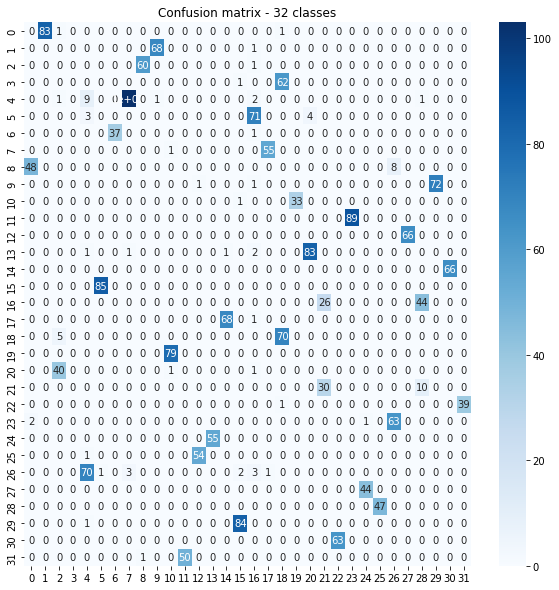

In [38]:
confusion_matrix= tf.math.confusion_matrix(
  all_labels_32,
  all_preds_32,
  num_classes=parmas_32_classes['num_classes']
)

plt.figure(figsize=(10, 10))
plt.title('Confusion matrix - 32 classes')
sns.heatmap(
  confusion_matrix.numpy(),
  annot=True,
  cmap='Blues'
)

In [39]:
#Model trained with 32 classes
parmas_16_classes = {
  'num_classes': 16,
  'input_shape': (SIZE_IMG, SIZE_IMG, 3),
  'type_extractor': 'vgg',
  'units': 1024,
  'inner_layers': 1
}
model_16 = AnimeClassifier(**parmas_16_classes)
model_16.build(input_shape=(None, *parmas_16_classes['input_shape']))
PATH_BEST_16_CLASSES = './models/vgg_16class_1024_units_aqr.h5'
model_16.load_weights(PATH_BEST_16_CLASSES)

TFRECORD_PATH_16 = './data/anime_data_16.tfrecord'
tf_record_16 = load_tfrecord_dataset(TFRECORD_PATH_16, SIZE_IMG)

all_ds_len = sum(1 for _ in tf_record_16)

n_train = int(all_ds_len * 0.8)
n_test = int(all_ds_len * 0.2)

tf_record_16 = tf_record_16.shuffle(n_train + n_test, seed=SEED)
tf_record_16 = tf_record_16.skip(n_train).take(n_test)
print(f'Total number of images or test: {n_test}')
tf_record_16 = tf_record_16.batch(32)

#Evaluate model and create confusion matrix
all_preds_16 = []
all_labels_16 = []
for images, label in tf_record_16:
  preds = model_16.predict(images)
  all_labels_16.extend(label)
  all_preds_16.extend(np.argmax(preds, axis=1))

Total number of images or test: 1276


<AxesSubplot:title={'center':'Confusion matrix - 16 classes'}>

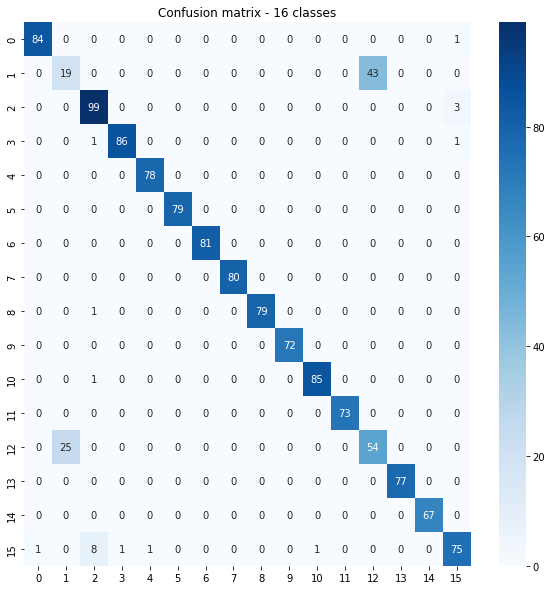

In [40]:
confusion_matrix = tf.math.confusion_matrix(
  all_labels_16,
  all_preds_16,
  num_classes=parmas_16_classes['num_classes']
)
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix - 16 classes')
sns.heatmap(
  confusion_matrix.numpy(),
  annot=True,
  cmap='Blues'
)

In [42]:
#Model trained with 32 classes
parmas_8_classes = {
  'num_classes': 8,
  'input_shape': (SIZE_IMG, SIZE_IMG, 3),
  'type_extractor': 'vgg',
  'units': 1024,
  'inner_layers': 1
}
model_8 = AnimeClassifier(**parmas_8_classes)
model_8.build(input_shape=(None, *parmas_8_classes['input_shape']))
PATH_BEST_8_CLASSES = './models/vgg_8class_1024_units.h5'
model_8.load_weights(PATH_BEST_8_CLASSES)

TFRECORD_PATH_8 = './data/anime_data_8.tfrecord'
tf_record_8 = load_tfrecord_dataset(TFRECORD_PATH_8, SIZE_IMG)

all_ds_len = sum(1 for _ in tf_record_8)

n_train = int(all_ds_len * 0.8)
n_test = int(all_ds_len * 0.2)

tf_record_8 = tf_record_8.shuffle(n_train + n_test, seed=SEED)
tf_record_8 = tf_record_8.skip(n_train).take(n_test)
print(f'Total number of images or test: {n_test}')
tf_record_8 = tf_record_8.batch(32)

#Evaluate model and create confusion matrix
all_preds_8 = []
all_labels_8 = []
for images, label in tf_record_8:
  preds = model_8.predict(images)
  all_labels_8.extend(label)
  all_preds_8.extend(np.argmax(preds, axis=1))

#

Total number of images or test: 662


<AxesSubplot:title={'center':'Confusion matrix - 8 classes'}>

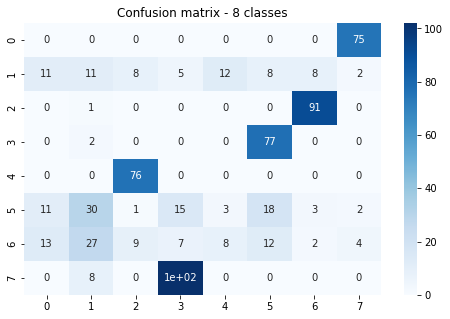

In [46]:
confusion_matrix = tf.math.confusion_matrix(
  all_labels_8,
  all_preds_8,
  num_classes=parmas_8_classes['num_classes']
)
plt.figure(figsize=(8, 5))
plt.title('Confusion matrix - 8 classes')
sns.heatmap(
  confusion_matrix.numpy(),
  annot=True,
  cmap='Blues'
)

### Rebuild custom model

In [ ]:
model = AnimeClassifier(
  num_classes=len(class_array),
  input_shape=(SIZE_IMG, SIZE_IMG, 3),
  type_extractor='vgg',
  units=UNITS,
  inner_layers=1
)
model.build(input_shape=(None, SIZE_IMG, SIZE_IMG, 3))
PATH_BEST = './models/vgg_16class_1024_units_aqr.h5'
model.load_weights(PATH_BEST)
model.summary()

### Calculate vector and similarity

In [ ]:
db1 = load_img("./images/db1.jpg", target_size=(224, 224))
db2 = load_img("./images/db2.jpeg", target_size=(224, 224))
nr1 = load_img("./images/nr1.webp", target_size=(224, 224))
db1 = np.array(db1)
db2 = np.array(db2)
nr1 = np.array(nr1)

images = preprocess_input(np.array([db1, db2, nr1]), mode='tf')

db1_v, db2_v, nr1_v = model.vectorize(images)

In [ ]:
cosine_similarity(db1_v, nr1_v)

In [ ]:
cosine_similarity(db1_v, db2_v)